## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import fastai
from fastai.utils.mem import *
import os

GPU_NO=0

os.environ["CUDA_VISIBLE_DEVICES"]=str(GPU_NO)
%env CUDA_VISIBLE_DEVICES={GPU_NO}

torch.cuda.set_device(GPU_NO)
torch.cuda.empty_cache()
#!nvidia-smi --id={GPU_NO}
print(torch.cuda.get_device_name())
print(f"total_memory {torch.cuda.get_device_properties(GPU_NO).total_memory/1024**2}")
print(f"{gpu_mem_get_free_no_cache()}MB of GPU RAM free")
#print(fastai.utils.show_install(show_nvidia_smi=True))
#print(fastai.utils.check_perf())


env: CUDA_VISIBLE_DEVICES=1
GeForce RTX 2080 Ti
total_memory 11019.4375
11007MB of GPU RAM free


In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
print(URLs.CAMVID)

https://s3.amazonaws.com/fast-ai-imagelocal/camvid


In [5]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/docker_home/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/docker_home/.fastai/data/camvid/labels'),
 PosixPath('/home/docker_home/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/docker_home/.fastai/data/camvid/images')]

In [6]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [7]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [8]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/docker_home/.fastai/data/camvid/images/0001TP_008880.png'),
 PosixPath('/home/docker_home/.fastai/data/camvid/images/0006R0_f02640.png'),
 PosixPath('/home/docker_home/.fastai/data/camvid/images/0016E5_06720.png')]

In [9]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/docker_home/.fastai/data/camvid/labels/Seq05VD_f03660_P.png'),
 PosixPath('/home/docker_home/.fastai/data/camvid/labels/0006R0_f03720_P.png'),
 PosixPath('/home/docker_home/.fastai/data/camvid/labels/0016E5_08027_P.png')]

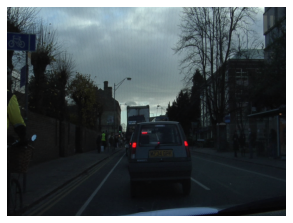

In [10]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [11]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

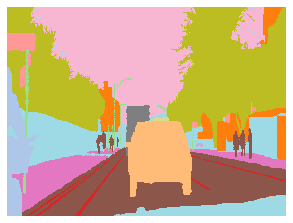

In [12]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [13]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]),
 tensor([[[26, 26, 26,  ..., 30, 30, 30],
          [26, 26, 26,  ..., 26, 30, 30],
          [26, 26, 26,  ..., 26, 26, 30],
          ...,
          [ 2,  2,  2,  ..., 30, 30, 30],
          [ 2,  2,  2,  ..., 30, 30, 30],
          [ 2,  2,  2,  ..., 30, 30, 30]]]))

In [14]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [15]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11007MB of GPU RAM free


In [16]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

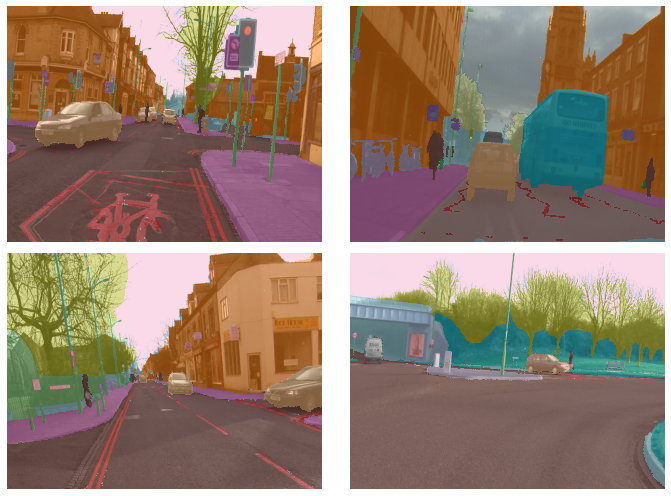

In [18]:
data.show_batch(2, figsize=(10,7))

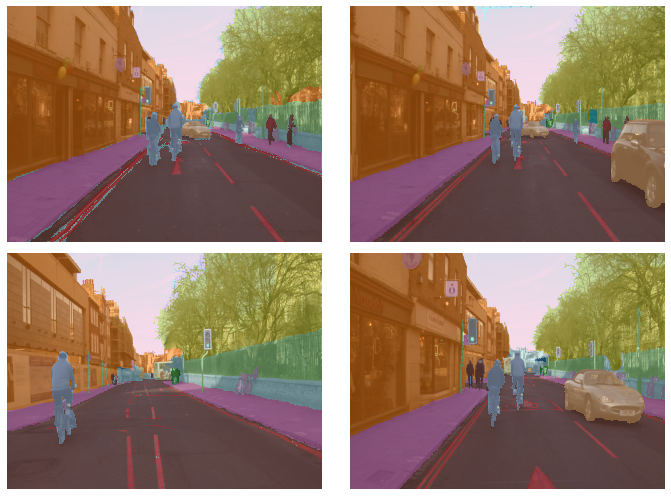

In [19]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [20]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [21]:
metrics=acc_camvid
# metrics=accuracy

In [22]:
wd=1e-2

In [23]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
#learn.model = torch.nn.DataParallel(learn.model,device_ids=[GPU_NO])

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


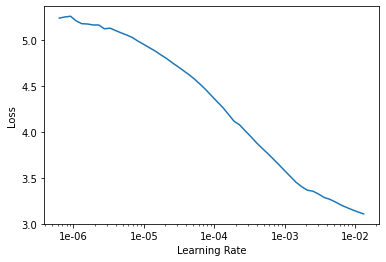

In [24]:
lr_find(learn)
learn.recorder.plot()

In [25]:
lr=3e-3

In [26]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.272886,0.884121,0.760997,00:39
1,0.877613,0.689402,0.823085,00:37
2,0.746368,0.656029,0.837828,00:37
3,0.693523,0.559754,0.854972,00:37
4,0.617194,0.477968,0.871038,00:37
5,0.798760,1.067382,0.745087,00:37
6,0.709731,0.474327,0.873187,00:37
7,0.582432,0.433416,0.887183,00:37
8,0.536518,0.498969,0.860681,00:37
9,0.485922,0.389221,0.889630,00:37


In [27]:
learn.save('stage-1')

In [28]:
learn.load('stage-1');

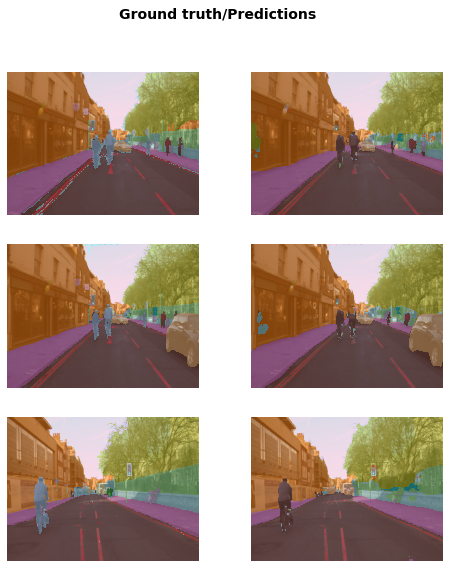

In [29]:
learn.show_results(rows=3, figsize=(8,9))

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(lr/400,lr/4)

In [32]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.415940,0.348989,0.896968,00:38
1,0.404851,0.327289,0.902091,00:38
2,0.396483,0.336133,0.899428,00:39
3,0.383969,0.321386,0.906579,00:38
4,0.373559,0.321886,0.905678,00:39
5,0.363503,0.322980,0.904549,00:39
6,0.347137,0.325153,0.906714,00:39
7,0.334774,0.306541,0.911501,00:39
8,0.331602,0.323056,0.907763,00:39
9,0.319288,0.289657,0.915651,00:39


In [33]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [35]:
gc.collect()
learn.purge()
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=2
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this object has been destroyed
this object has been destroyed
using bs=2, have 10162MB of GPU RAM free


In [36]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [37]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [38]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


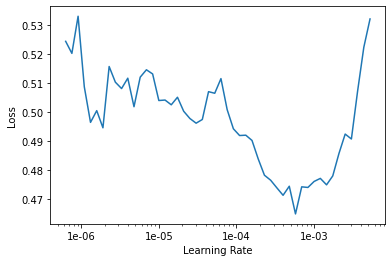

In [40]:
lr_find(learn)
learn.recorder.plot()

In [41]:
lr=1e-3

In [42]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.390523,0.327420,0.907737,02:33
1,0.367152,0.303106,0.919225,02:31
2,0.353027,0.326649,0.909146,02:32
3,0.350257,0.316005,0.910790,02:32
4,0.364007,0.307347,0.913645,02:32
5,0.347071,0.321121,0.912412,02:31
6,0.388444,0.310535,0.915076,02:31
7,0.344987,0.324058,0.915065,02:32
8,0.290060,0.266961,0.929789,02:32
9,0.248136,0.253818,0.932934,02:32


In [43]:
learn.save('stage-1-big')

In [44]:
learn.load('stage-1-big');

In [45]:
learn.unfreeze()

In [46]:
lrs = slice(1e-6,lr/10)

In [47]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.232157,0.257448,0.932333,02:35
1,0.225960,0.262068,0.932261,02:37
2,0.219980,0.279618,0.926875,02:37
3,0.221467,0.251403,0.935121,02:37
4,0.206196,0.266178,0.933193,02:37
5,0.208206,0.271621,0.932804,02:38
6,0.207209,0.273514,0.932671,02:38
7,0.200496,0.258563,0.935330,02:38
8,0.195990,0.266596,0.933517,02:38
9,0.198422,0.267459,0.932940,02:38


In [48]:
learn.save('stage-2-big')

In [49]:
learn.load('stage-2-big');

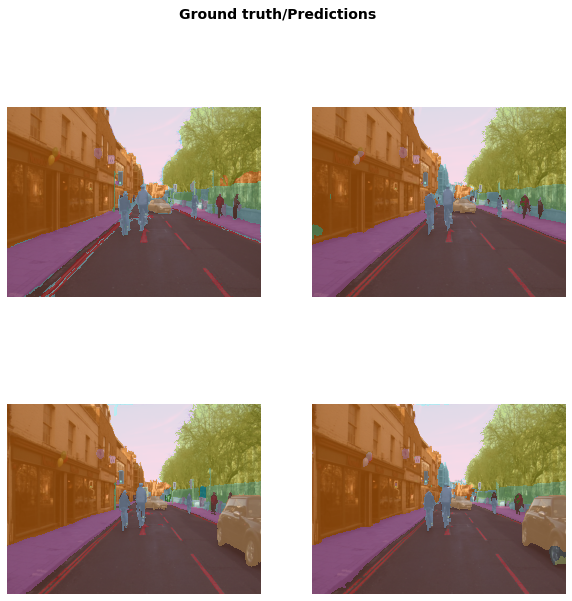

In [50]:
learn.show_results(rows=3, figsize=(10,10))